#Two-stage human hair segmentation in the wild using deep shape prior

https://hal.archives-ouvertes.fr/hal-02890593/file/PRLETTERS-D-19-00788R2-P5-12%20(2).pdf

 In this paper,
we propose a novel hair segmentation approach integrating a deep shape prior into a carefully designed
two-stage Fully Convolutional Neural Network (FCNN) pipeline. First, we utilize a FCNN with an
Atrous Spatial Pyramid Pooling (ASPP) module to train a human hair shape prior based on a specific
distance transform. In the second stage, we combine the hair shape prior and the original image
to form the input of a symmetric encoder-decoder FCNN with a border refinement module to get the
final hair segmentation output

4.1. Datasets
We conducted our experiments on LFW-Part dataset (Kae
et al., 2013) and the newly-released Figaro-1k (Muhammad
et al., 2018) dataset. The LFW-Part dataset is a face parsing
dataset with hair annotation which consists of 2927 images. To
the best of our knowledge, Figaro-1k is the only hair analysis dataset in the wild with precise hair annotation. It consists
of 1050 images (210 for validation) and manually annotated
ground truth hair masks, which varies in seven hair styles, different hair colors, length and levels of background complexity.

http://vis-www.cs.umass.edu/lfw/part_labels/


Each image is a 250x250 jpg, detected and centered using the openCV
implementation of Viola-Jones face detector.  The cropping region
returned by the detector was then automatically enlarged by a factor
of 2.2 in each dimension to capture more of the head and then scaled
to a uniform size.




#Imports

In [ ]:
import sys, os, argparse
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from PIL import Image
from google.colab.patches import cv2_imshow
import time
import requests

from skimage.transform import resize
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from skimage.io import imread
from skimage.transform import resize
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D

from keras.models import Model, load_model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import add

# !pip install -U tensorboard_plugin_profile

In [ ]:
!pip install -U tensorboard_plugin_profile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 12.2 MB/s 


#Helper Functioms

In [ ]:
def extract_red_channel(img): 
    
    dim=(img.shape[0],img.shape[1])
    if (img is not None):
            segment = img[:, :, 2]   # the hair segment is the red channel
            resized = cv2.resize(segment, dim, interpolation = cv2.INTER_AREA)
            
            return resized


In [ ]:
def imgpath2processedImg(path,im_height,im_width,grayscale=None ):
    if grayscale:
       img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    else:
      img = cv2.imread(path)
      img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x_img = img_to_array(img)
    x_img = resize(x_img, (im_height, im_width,x_img.shape[2]), mode = 'constant', preserve_range = True)
    x_img=x_img/255.0
    return x_img

In [ ]:
def folder2list_of_Paths(folder):
   allmasks = os.listdir(folder)
   return allmasks



In [ ]:
def visualize_face_mask(img, mask):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

    ax1.imshow(img, interpolation = 'bilinear', vmin=0, vmax=1)
    ax1.contour(mask.squeeze(), colors = 'r', linewidths = 8, levels = [0.5])
        
    ax1.set_title('ORIGINAL FACE')

    ax2.imshow(mask.squeeze(), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('GROUND TRUTH HAIR MASK')

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    import random
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X)-1)

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('FACE')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('GT MASK')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Mask predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Mask Predicted Binary')
    
    
def load_type_images(path_gray, path_rgb):
    #Load images from the assigments in rgb and gray
    #A previous script has already resized the images to 128x128 and create gray version of images
    
    ids_gray = next(os.walk(path_gray))[2] # list of names of all images
    print("No. of curl images = ", len(ids_gray))
    
    X_gray = np.zeros((len(ids_gray), im_height, im_width, 1), dtype=np.float32)
    X_rgb = np.zeros((len(ids_gray), im_height, im_width, 3), dtype=np.float32)
    X_name = []
    
    for n in range(len(ids_gray)):
        img = load_img(path_gray+ids_gray[n], grayscale=True)
        img_rgb = load_img(path_rgb+ids_gray[n], grayscale=False)
        
        x_img = img_to_array(img)
        x_img_rgb = img_to_array(img_rgb)
        x_img = resize(x_img, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
        x_img_rgb = resize(x_img_rgb, (im_height, im_width, 3), mode = 'constant', preserve_range = True)
        X_gray[n] = x_img/255.0
        X_rgb[n] = x_img_rgb/1.0
        X_name.append(ids_gray[n])
    
    return X_gray, X_rgb, X_name
    
def hair_extract(X, binary_mask):
    X_ = 1.0*X
    X_rgb_segment = X_
    for image in range(len(X)):
        for channel in range(3):
            mask = binary_mask[image, :, :,0]
            sample = X_[image, :, :, channel]
            X_rgb_segment[image, :, :, channel] = np.multiply(sample, mask)
    return X_rgb_segment

def save_hair_segment(Ximage, Xname, folder_final):
    
    for i in range(len(Ximage)):
        cv2.imwrite(folder_final+Xname[i], Ximage[i])

#Get Data

**lfw** stands for **Labeled Faces in the Wild**.
We will be using OriginalImages and GroundTruthImages to train our model. In this section we are downlaeding and and unzipping them.

We need extra data preprocessing stage because this dataset is quite messy. There are ~11600 images saved in +1000 folders. And inside the ground truth images, there are faulty images which returns NoneType if we try to read them. We will deal with this mess in preprocessing step.



 


In [ ]:
%%capture

!curl -k -L --output OriginalImages.tgz http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz .
!curl -k -L --output GroundTruthImages.tgz http://vis-www.cs.umass.edu/lfw/part_labels/parts_lfw_funneled_gt_images.tgz .


!tar zxvf /content/OriginalImages.tgz
!tar zxvf /content/GroundTruthImages.tgz

folder_images = "/content/lfw_funneled/"
folder_mask = "/content/parts_lfw_funneled_gt_images/"

!mkdir hair_masks
!mkdir images
!mkdir weights

hair_masks_folder = "/content/hair_masks/"
images_folder = "/content/images/"

# !curl -k -L --output figaro1k.zip http://projects.i-ctm.eu/sites/default/files/AltroMateriale/207_Michele%20Svanera/Figaro1k.zip


#Inspect Data

This is for initial inspection to make sure we get correct data.

##Inspect Input Images

(250, 250, 3)


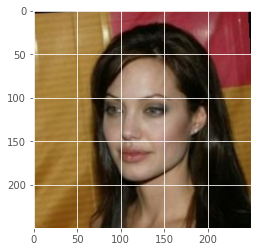

In [ ]:
example_ImagePath= "/content/lfw_funneled/Angelina_Jolie/Angelina_Jolie_0009.jpg"
img = cv2.imread(example_ImagePath)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)


##Inspect Input Images superpixelled

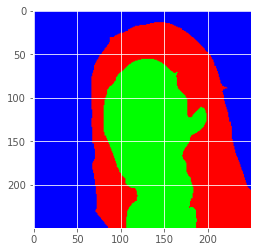

In [ ]:
example_labelImagePath= "/content/parts_lfw_funneled_gt_images/Angelina_Jolie_0009.ppm"

img = cv2.imread(example_labelImagePath)

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)

#Preprocessing

I mentioned in GET DATA section how messy data is. I wrote some not-so-much-clean codes to bring order to this evil chaos. All you need to know is after running this section there will be 2 folders with names "hair_masks_folder" and "image_folder". 

##Create List of Input image Paths 

In [ ]:
allimages=[]
allfolders = os.listdir(folder_images)
allimage_paths=[]

for f in allfolders:
  if os.path.isdir(folder_images+f):
  
    img_names = os.listdir(folder_images+f)
    for name in img_names:
      if ".jpg" in name :
        f_name= f+"/"+name
        allimage_paths.append(folder_images+f_name)



##Create List of nonempty Mask Paths 

In [ ]:
allmasks = os.listdir(folder_mask)
nonempty_masks=[]
for e in allmasks:
  img = cv2.imread(folder_mask+e)
  if img is not None:
    nonempty_masks.append(e)
 

##Pair Images and Masks

In [ ]:
pairs=[]
for e in nonempty_masks:
  for y in allimage_paths:
    if e[:-4] in y:
      pairs.append((y,folder_mask+e))

all_usable_images=[]
all_usable_masks=[]

for img_path, lbl_path in pairs:
    all_usable_images.append(img_path)
    all_usable_masks.append(lbl_path)


##Create image and Mask folders

In [ ]:

dim=(224,224)
count=0
for maskpath in all_usable_masks:
  
    img = cv2.imread(maskpath)
    
    red_channel=extract_red_channel(img)
    
    new_name=str(count)+".jpg"
    cv2.imwrite(hair_masks_folder+new_name,red_channel)
    count=count+1

count=0
for imgpath in all_usable_images:
  
    img = cv2.imread(imgpath)
  
    new_name=str(count)+".jpg"
    cv2.imwrite(images_folder+new_name,img)
    count=count+1



##Delete useless things

In [ ]:
!rm -r  /content/parts_lfw_funneled_gt_images
!rm -r  /content/lfw_funneled
!rm -r  /content/GroundTruthImages.tgz
!rm -r  /content/OriginalImages.tgz
!rm -r  /content/sample_data
!rm -r  /mylife/myexgf

rm: cannot remove '/mylife/myexgf': No such file or directory


#Split Data Train/Valid

In [ ]:

X=folder2list_of_Paths(images_folder)
y=folder2list_of_Paths(hair_masks_folder)

print(len(X))
print(len(y))

print(X[:5])
print(y[:5])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
print('Shape training set X_train is ', np.shape(X_train))
print('Shape training set label y_train is ', np.shape(y_train))
print('Shape validation set X_valid is ', np.shape(X_valid))
print('Shape validation set y_valid is ', np.shape(y_valid))



2929
2929
['890.jpg', '2334.jpg', '1060.jpg', '91.jpg', '14.jpg']
['890.jpg', '2334.jpg', '1060.jpg', '91.jpg', '14.jpg']
Shape training set X_train is  (2636,)
Shape training set label y_train is  (2636,)
Shape validation set X_valid is  (293,)
Shape validation set y_valid is  (293,)


#Define DataGenerator

Here I implement a PyTorch DataLoader alternative for Keras. The reason we use Loaders is to not load all data to memory at once. Because we are processing data in batches there is no need to load all images at once.

By using this class, we can create Loader/Generator objects with our imagepaths data.During the model training these imagepaths will be converted to images in batches(32). 


In [ ]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size :  (idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x_transformed=[]
        batch_y_transformed=[]
        for e in batch_x:
           batch_x_transformed.append(imgpath2processedImg(images_folder+e,224,224))
        for e in batch_y:
           batch_y_transformed.append(imgpath2processedImg(hair_masks_folder+e,224,224, grayscale=True))
        
        batch_x_array=np.stack(batch_x_transformed)
        batch_y_array=np.stack(batch_y_transformed)


        return batch_x_array,batch_y_array

#Visualize Data&GT

Last check if data is good to go

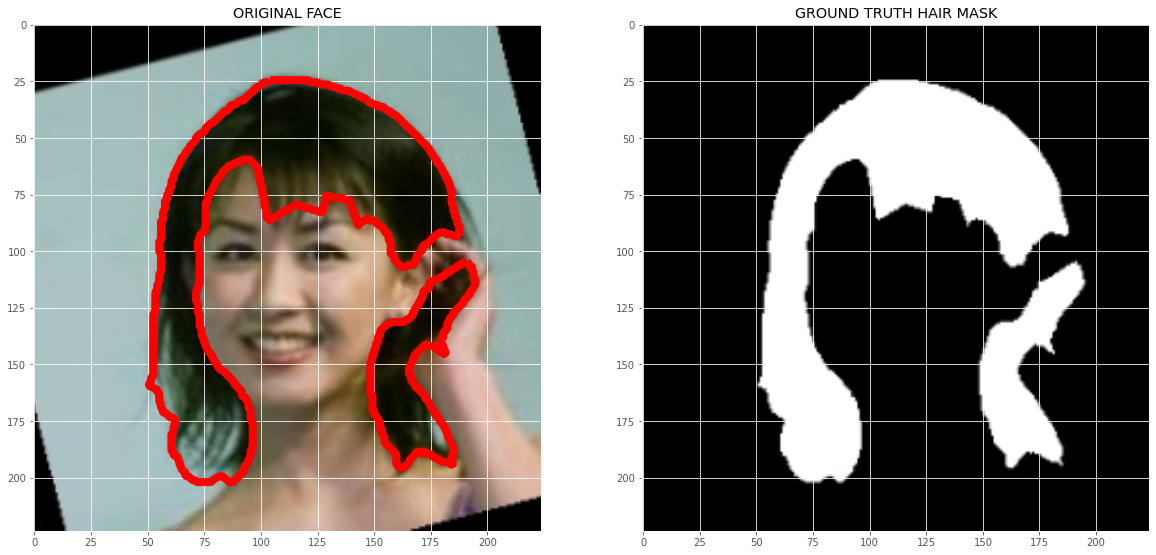

In [ ]:

im_height=224
im_width=224

example_img =imgpath2processedImg(images_folder+X_train[10],im_height,im_width)
example_mask =imgpath2processedImg(hair_masks_folder+y_train[10],im_height,im_width, grayscale=True)

visualize_face_mask(example_img, example_mask)

#Models

##Unet

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def UNET(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

#Prepare Validation Data

In [ ]:
validation_images=[]
validation_masks=[]
for e in X_valid:
     validation_images.append(imgpath2processedImg(images_folder+e,224,224))
for e in y_valid:
     validation_masks.append(imgpath2processedImg(hair_masks_folder+e,224,224, grayscale=True))


valid_data=np.stack(validation_images)
valid_masks=np.stack(validation_masks)
print(valid_data.shape)
print(valid_masks.shape)

(293, 224, 224, 3)
(293, 224, 224, 1)


#Main

##Train Model

In [ ]:
number_channel=3
input_img = Input((im_height, im_width, number_channel), name='img')
model = UNET(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

# logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
#                                                  histogram_freq = 1,
#                                                  profile_batch = '500,520')

callbacks = [
    # tboard_callback,
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('weights/weights.h5', verbose=1, save_best_only=True, save_weights_only=True)
]



batch_size=32
train_generator = DataGenerator( X_train, y_train, batch_size)
# test_generator = DataGenerator( X_valid, y_valid, batch_size)


results = model.fit(train_generator, batch_size=32, epochs=50,
                    callbacks=callbacks,
                    verbose= 1,
                    validation_data=(valid_data, valid_masks))	



Epoch 1/50
83/83 [==============================] - ETA: 0s - loss: 0.5380 - accuracy: 0.7565
Epoch 1: val_loss improved from inf to 0.77312, saving model to weights/weights.h5
83/83 [==============================] - 70s 681ms/step - loss: 0.5380 - accuracy: 0.7565 - val_loss: 0.7731 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 2/50
83/83 [==============================] - ETA: 0s - loss: 0.3770 - accuracy: 0.8609
Epoch 2: val_loss improved from 0.77312 to 0.47896, saving model to weights/weights.h5
83/83 [==============================] - 47s 572ms/step - loss: 0.3770 - accuracy: 0.8609 - val_loss: 0.4790 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 3/50
83/83 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.8624
Epoch 3: val_loss did not improve from 0.47896
83/83 [==============================] - 49s 587ms/step - loss: 0.2932 - accuracy: 0.8624 - val_loss: 0.5084 - val_accuracy: 0.7597 - lr: 0.0010
Epoch 4/50
83/83 [==============================] - ETA: 0s - loss

###Load Model

In [ ]:
# model.load_weights('/content/weights/weights.h5'')

##Plot Predictions 

10/10 [==============================] - 1s 79ms/step


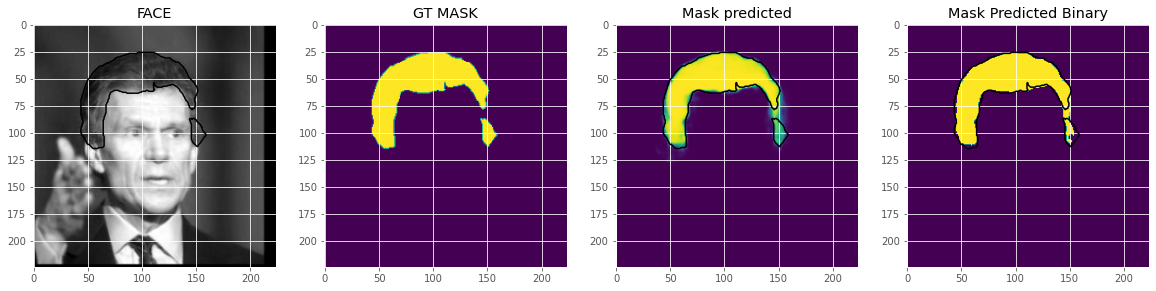

In [ ]:

preds_train = model.predict(valid_data, verbose=1)
preds_val = model.predict(valid_data, verbose=1)


# Threshold predictions
preds_train_t = (preds_train > 0.6).astype(np.uint8)
preds_val_t = (preds_val > 0.6).astype(np.uint8)

plot_sample(valid_data, valid_masks, preds_val, preds_val_t)
